## OPTIMIZACION DE PARAMETROS RANDOM FOREST

In [1]:
import pandas as pd

dataset_work_3 = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work_3.iloc[:,:-1]
y = dataset_work_3.iloc[:,-1].values
dataset_work_3.shape

(6435823, 16)

In [2]:
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Registro del tiempo de inicio
start_time = time.time()

# 1. Muestreo reducido (5% del dataset)
sample_size = int(0.05 * len(dataset_work_3))
dataset_sample = dataset_work_3.sample(n=sample_size, random_state=42)

# 2. Separar las características (X) y la variable objetivo (y)
X = dataset_sample.drop(columns=["MOROSIDAD"])
y = dataset_sample["MOROSIDAD"]

# 3. Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 5. Espacio de búsqueda para los hiperparámetros
print("Espacio de búsqueda para los hiperparámetros")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 6. Inicializar el clasificador y RandomizedSearchCV
print("Inicializando RandomizedSearchCV")
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Reducir el número de combinaciones
    cv=2,  # Validación cruzada con 2 folds
    n_jobs=-1,  # Usar múltiples núcleos para mejorar el rendimiento
    verbose=2,
    random_state=42,
    scoring='roc_auc'
)

# 7. Ajustar el modelo con la muestra del dataset
random_search.fit(X_train, y_train)

# 8. Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# 9. Entrenar el modelo final con todos los datos utilizando los mejores parámetros
best_params = random_search.best_params_
best_model = RandomForestClassifier(**best_params, random_state=42)

# Escalar el dataset completo
X_full = dataset_work_3.drop(columns=["MOROSIDAD"])
y_full = dataset_work_3["MOROSIDAD"]
X_full_scaled = scaler.transform(X_full)

# División de los datos para el modelo final
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full_scaled, y_full, test_size=0.3, random_state=42)

# Ajustar el modelo con el dataset completo
best_model.fit(X_train_full, y_train_full)

# Hacer predicciones y evaluar el modelo
y_pred = best_model.predict(X_test_full)
y_pred_proba = best_model.predict_proba(X_test_full)[:, 1]

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_full, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test_full, y_pred))

roc_auc = roc_auc_score(y_test_full, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")


Espacio de búsqueda para los hiperparámetros
Inicializando RandomizedSearchCV
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Mejores parámetros encontrados:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}

Matriz de Confusión:
[[889358 231481]
 [120213 689695]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83   1120839
           1       0.75      0.85      0.80    809908

    accuracy                           0.82   1930747
   macro avg       0.81      0.82      0.82   1930747
weighted avg       0.83      0.82      0.82   1930747

ROC AUC: 0.92
El tiempo total de ejecución fue de 70 minutos y 41.12 segundos.


## **Matriz de Confusión con Mapa de Calor**

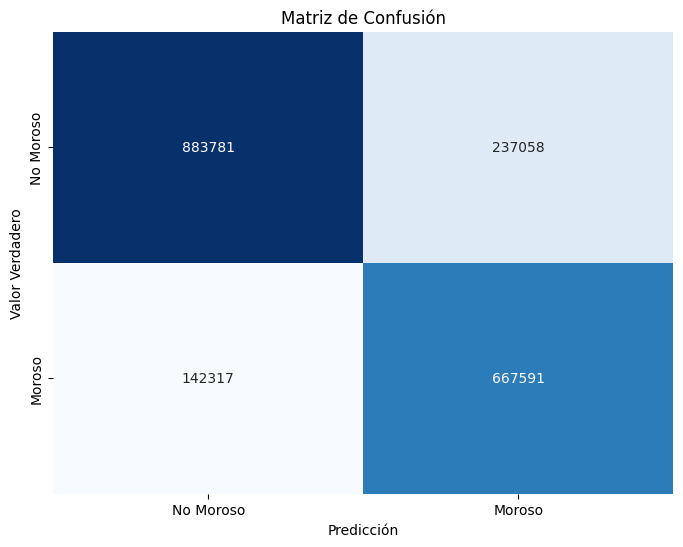

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test_full, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Moroso', 'Moroso'], yticklabels=['No Moroso', 'Moroso'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Verdadero")
plt.show()